## Creating Custom Datasets and Finetuning Pre-trained Networks
In this notebook you have to create custom datasets for PyTorch and use this dataset to finetune certain pre-trained neural networks and observe the results.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import torchvision
import PIL.Image
import torch.nn as nn
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [2]:
batch_size = 10
num_epochs = 5
learning_rate = 0.0001

### Creating Custom Datasets
Your first task is to create a pipeline for the custom dataset so that you can load it using a dataloader. Download the dataset provided in the assignment webpage and complete the following block of code so that you can load it as if it was a standard dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        if(train):
            dir = root_dir + '/train'
        else :
            dir = root_dir + '/test'
        self.transform = transform
        self.img = []
        self.label = []
        for file_path in glob.glob(dir+'/*/*.png'):
            image = PIL.Image.open(file_path)
            self.img.append(image.convert('RGB'))
            self.label.append(ord(file_path.split('/')[-2]) - ord('A')) #ord makes A,B,C.. to 0,1,2,.. respectively
            
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.img)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        if self.transform is None:
            return (self.img[idx],self.label[idx])
        else:
            img_transformed = self.transform(self.img[idx])
            return (img_transformed,self.label[idx])

We shall now load the dataset. You just need to supply the `root_dir` in the block below and if you implemented the above block correctly, it should work without any issues.

In [4]:

# train_dataset = CDATA(root_dir='./notMNIST_small', train=True, transform=None)
# img,label = train_dataset.__getitem__(10100)
# print(label)


Size of train dataset: 16854
Size of test dataset: 1870
Train images
Test images


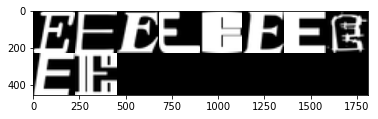

In [5]:
composed_transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='./notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir

# Let's check the size of the datasets, if implemented correctly they should be 16854 and 1870 respectively
print('Size of train dataset: %d' % len(train_dataset))
print('Size of test dataset: %d' % len(test_dataset))

# Create loaders for the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
print("Train images")
imshow(torchvision.utils.make_grid(train_images))

test_dataiter = iter(test_loader)
test_images, test_labels = test_dataiter.next()
print("Test images")
imshow(torchvision.utils.make_grid(test_images))

### VGG-16 and Resnet-18
Now that you have created the dataset we can use it for training and testing neural networks. VGG-16 and Resnet-18 are both well-known deep-net architectures. VGG-16 is named as such since it has 16 layers in total (13 convolution and 3 fully-connected). Resnet-18 on the other hand is a Resnet architecture that uses skip-connections. PyTorch provides pre-trained models of both these architectures and we shall be using them directly. If you are interested in knowing how they have been defined do take a look at the source, [VGG](https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py), [Resnet](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [6]:
vgg16 = models.vgg16(pretrained=True)
resnet18 = models.resnet18(pretrained=True)

# Code to change the last layers so that they only have 10 classes as output
vgg16.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(4096, 10),
)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Add code for using CUDA here if it is available
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    vgg16.cuda()
    resnet18.cuda()

Define loss functions and optimizers

In [7]:
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer_vgg16 = torch.optim.Adam(vgg16.parameters(), lr=learning_rate)# Use Adam optimizer, use learning_rate hyper parameter
optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)# Use Adam optimizer, use learning_rate hyper parameter

#### Finetuning
Finetuning is nothing but training models after their weights have been loaded. This allows us to start at a better position than training from scratch. Since the models created already have weights loaded, you simply need to write a training loop.

In [8]:
def train_vgg16():
    # Write loops so as to train the model for N epochs, use num_epochs hyper parameter
    # Train/finetune the VGG-16 network
    # Store the losses for every epoch and generate a graph using matplotlib
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer_vgg16.zero_grad()  # zero the gradient buffer
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_vgg16.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

    
def train_resnet18():
    # Same as above except now using the Resnet-18 network
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer_resnet18.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_resnet18.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()


Now let us start the training/finetuning

Epoch [1/5], Step [10/1685], Loss: 1.8709
Epoch [1/5], Step [20/1685], Loss: 0.8383
Epoch [1/5], Step [30/1685], Loss: 0.8559
Epoch [1/5], Step [40/1685], Loss: 0.1617
Epoch [1/5], Step [50/1685], Loss: 0.7611
Epoch [1/5], Step [60/1685], Loss: 0.3271
Epoch [1/5], Step [70/1685], Loss: 1.1896
Epoch [1/5], Step [80/1685], Loss: 0.8737
Epoch [1/5], Step [90/1685], Loss: 0.2362
Epoch [1/5], Step [100/1685], Loss: 0.3017
Epoch [1/5], Step [110/1685], Loss: 0.1826
Epoch [1/5], Step [120/1685], Loss: 0.1660
Epoch [1/5], Step [130/1685], Loss: 0.3534
Epoch [1/5], Step [140/1685], Loss: 0.2373
Epoch [1/5], Step [150/1685], Loss: 0.0788
Epoch [1/5], Step [160/1685], Loss: 0.5949
Epoch [1/5], Step [170/1685], Loss: 0.0899
Epoch [1/5], Step [180/1685], Loss: 0.5950
Epoch [1/5], Step [190/1685], Loss: 0.1118
Epoch [1/5], Step [200/1685], Loss: 0.2481
Epoch [1/5], Step [210/1685], Loss: 0.2474
Epoch [1/5], Step [220/1685], Loss: 0.1224
Epoch [1/5], Step [230/1685], Loss: 0.6279
Epoch [1/5], Step [2

Epoch [2/5], Step [230/1685], Loss: 0.2328
Epoch [2/5], Step [240/1685], Loss: 0.0733
Epoch [2/5], Step [250/1685], Loss: 0.0017
Epoch [2/5], Step [260/1685], Loss: 0.0363
Epoch [2/5], Step [270/1685], Loss: 0.1969
Epoch [2/5], Step [280/1685], Loss: 0.0243
Epoch [2/5], Step [290/1685], Loss: 0.0954
Epoch [2/5], Step [300/1685], Loss: 0.4884
Epoch [2/5], Step [310/1685], Loss: 0.0828
Epoch [2/5], Step [320/1685], Loss: 0.0059
Epoch [2/5], Step [330/1685], Loss: 0.0003
Epoch [2/5], Step [340/1685], Loss: 0.0035
Epoch [2/5], Step [350/1685], Loss: 0.0152
Epoch [2/5], Step [360/1685], Loss: 0.0321
Epoch [2/5], Step [370/1685], Loss: 0.4560
Epoch [2/5], Step [380/1685], Loss: 0.0039
Epoch [2/5], Step [390/1685], Loss: 0.0152
Epoch [2/5], Step [400/1685], Loss: 0.1276
Epoch [2/5], Step [410/1685], Loss: 0.0475
Epoch [2/5], Step [420/1685], Loss: 0.1177
Epoch [2/5], Step [430/1685], Loss: 0.0153
Epoch [2/5], Step [440/1685], Loss: 0.0001
Epoch [2/5], Step [450/1685], Loss: 1.2015
Epoch [2/5]

Epoch [3/5], Step [450/1685], Loss: 0.0001
Epoch [3/5], Step [460/1685], Loss: 0.0380
Epoch [3/5], Step [470/1685], Loss: 0.0009
Epoch [3/5], Step [480/1685], Loss: 0.0020
Epoch [3/5], Step [490/1685], Loss: 0.1929
Epoch [3/5], Step [500/1685], Loss: 0.0002
Epoch [3/5], Step [510/1685], Loss: 0.1869
Epoch [3/5], Step [520/1685], Loss: 0.2659
Epoch [3/5], Step [530/1685], Loss: 0.4002
Epoch [3/5], Step [540/1685], Loss: 0.2875
Epoch [3/5], Step [550/1685], Loss: 0.0118
Epoch [3/5], Step [560/1685], Loss: 0.0270
Epoch [3/5], Step [570/1685], Loss: 0.1193
Epoch [3/5], Step [580/1685], Loss: 0.0026
Epoch [3/5], Step [590/1685], Loss: 0.4208
Epoch [3/5], Step [600/1685], Loss: 0.0060
Epoch [3/5], Step [610/1685], Loss: 0.0887
Epoch [3/5], Step [620/1685], Loss: 0.1700
Epoch [3/5], Step [630/1685], Loss: 0.0399
Epoch [3/5], Step [640/1685], Loss: 0.4844
Epoch [3/5], Step [650/1685], Loss: 0.0002
Epoch [3/5], Step [660/1685], Loss: 0.0053
Epoch [3/5], Step [670/1685], Loss: 0.0007
Epoch [3/5]

Epoch [4/5], Step [670/1685], Loss: 0.0206
Epoch [4/5], Step [680/1685], Loss: 0.0009
Epoch [4/5], Step [690/1685], Loss: 0.0006
Epoch [4/5], Step [700/1685], Loss: 0.0170
Epoch [4/5], Step [710/1685], Loss: 0.0117
Epoch [4/5], Step [720/1685], Loss: 0.0001
Epoch [4/5], Step [730/1685], Loss: 0.0000
Epoch [4/5], Step [740/1685], Loss: 0.2918
Epoch [4/5], Step [750/1685], Loss: 0.0000
Epoch [4/5], Step [760/1685], Loss: 0.0021
Epoch [4/5], Step [770/1685], Loss: 0.3118
Epoch [4/5], Step [780/1685], Loss: 0.0439
Epoch [4/5], Step [790/1685], Loss: 0.0749
Epoch [4/5], Step [800/1685], Loss: 0.0773
Epoch [4/5], Step [810/1685], Loss: 0.0002
Epoch [4/5], Step [820/1685], Loss: 0.0004
Epoch [4/5], Step [830/1685], Loss: 0.0004
Epoch [4/5], Step [840/1685], Loss: 0.0000
Epoch [4/5], Step [850/1685], Loss: 0.0037
Epoch [4/5], Step [860/1685], Loss: 0.8434
Epoch [4/5], Step [870/1685], Loss: 0.0002
Epoch [4/5], Step [880/1685], Loss: 0.0003
Epoch [4/5], Step [890/1685], Loss: 0.0591
Epoch [4/5]

Epoch [5/5], Step [890/1685], Loss: 0.0183
Epoch [5/5], Step [900/1685], Loss: 0.0291
Epoch [5/5], Step [910/1685], Loss: 0.0001
Epoch [5/5], Step [920/1685], Loss: 0.0975
Epoch [5/5], Step [930/1685], Loss: 0.0010
Epoch [5/5], Step [940/1685], Loss: 0.0002
Epoch [5/5], Step [950/1685], Loss: 0.1650
Epoch [5/5], Step [960/1685], Loss: 0.0450
Epoch [5/5], Step [970/1685], Loss: 0.0002
Epoch [5/5], Step [980/1685], Loss: 0.0000
Epoch [5/5], Step [990/1685], Loss: 0.4499
Epoch [5/5], Step [1000/1685], Loss: 0.0831
Epoch [5/5], Step [1010/1685], Loss: 0.0205
Epoch [5/5], Step [1020/1685], Loss: 0.3422
Epoch [5/5], Step [1030/1685], Loss: 0.0037
Epoch [5/5], Step [1040/1685], Loss: 0.0055
Epoch [5/5], Step [1050/1685], Loss: 0.0048
Epoch [5/5], Step [1060/1685], Loss: 0.0011
Epoch [5/5], Step [1070/1685], Loss: 0.0000
Epoch [5/5], Step [1080/1685], Loss: 0.3024
Epoch [5/5], Step [1090/1685], Loss: 0.0506
Epoch [5/5], Step [1100/1685], Loss: 0.0082
Epoch [5/5], Step [1110/1685], Loss: 0.0073

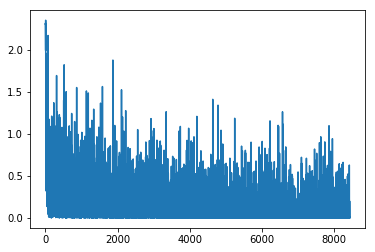

CPU times: user 1h 24min 24s, sys: 23min 31s, total: 1h 47min 55s
Wall time: 1h 45min 55s
Epoch [1/5], Step [10/1685], Loss: 1.1559
Epoch [1/5], Step [20/1685], Loss: 1.2208
Epoch [1/5], Step [30/1685], Loss: 0.6937
Epoch [1/5], Step [40/1685], Loss: 0.7589
Epoch [1/5], Step [50/1685], Loss: 0.3285
Epoch [1/5], Step [60/1685], Loss: 0.7161
Epoch [1/5], Step [70/1685], Loss: 0.7294
Epoch [1/5], Step [80/1685], Loss: 0.0515
Epoch [1/5], Step [90/1685], Loss: 0.4287
Epoch [1/5], Step [100/1685], Loss: 0.3745
Epoch [1/5], Step [110/1685], Loss: 1.0108
Epoch [1/5], Step [120/1685], Loss: 0.1670
Epoch [1/5], Step [130/1685], Loss: 0.5750
Epoch [1/5], Step [140/1685], Loss: 0.2065
Epoch [1/5], Step [150/1685], Loss: 0.5113
Epoch [1/5], Step [160/1685], Loss: 0.1648
Epoch [1/5], Step [170/1685], Loss: 0.1559
Epoch [1/5], Step [180/1685], Loss: 0.4603
Epoch [1/5], Step [190/1685], Loss: 0.4126
Epoch [1/5], Step [200/1685], Loss: 0.2340
Epoch [1/5], Step [210/1685], Loss: 0.2981
Epoch [1/5], Ste

Epoch [2/5], Step [210/1685], Loss: 0.0813
Epoch [2/5], Step [220/1685], Loss: 0.1621
Epoch [2/5], Step [230/1685], Loss: 0.3073
Epoch [2/5], Step [240/1685], Loss: 0.2350
Epoch [2/5], Step [250/1685], Loss: 0.0173
Epoch [2/5], Step [260/1685], Loss: 0.1221
Epoch [2/5], Step [270/1685], Loss: 0.0774
Epoch [2/5], Step [280/1685], Loss: 0.0046
Epoch [2/5], Step [290/1685], Loss: 0.0275
Epoch [2/5], Step [300/1685], Loss: 0.3803
Epoch [2/5], Step [310/1685], Loss: 0.1575
Epoch [2/5], Step [320/1685], Loss: 0.4336
Epoch [2/5], Step [330/1685], Loss: 0.1423
Epoch [2/5], Step [340/1685], Loss: 0.0131
Epoch [2/5], Step [350/1685], Loss: 0.0057
Epoch [2/5], Step [360/1685], Loss: 0.2948
Epoch [2/5], Step [370/1685], Loss: 0.0111
Epoch [2/5], Step [380/1685], Loss: 0.0105
Epoch [2/5], Step [390/1685], Loss: 0.1925
Epoch [2/5], Step [400/1685], Loss: 0.0524
Epoch [2/5], Step [410/1685], Loss: 0.0137
Epoch [2/5], Step [420/1685], Loss: 0.0132
Epoch [2/5], Step [430/1685], Loss: 0.3563
Epoch [2/5]

Epoch [3/5], Step [430/1685], Loss: 0.0596
Epoch [3/5], Step [440/1685], Loss: 0.0144
Epoch [3/5], Step [450/1685], Loss: 0.3095
Epoch [3/5], Step [460/1685], Loss: 0.1996
Epoch [3/5], Step [470/1685], Loss: 0.2553
Epoch [3/5], Step [480/1685], Loss: 0.0036
Epoch [3/5], Step [490/1685], Loss: 0.0033
Epoch [3/5], Step [500/1685], Loss: 0.1546
Epoch [3/5], Step [510/1685], Loss: 0.1483
Epoch [3/5], Step [520/1685], Loss: 0.0457
Epoch [3/5], Step [530/1685], Loss: 0.0022
Epoch [3/5], Step [540/1685], Loss: 0.2137
Epoch [3/5], Step [550/1685], Loss: 0.0087
Epoch [3/5], Step [560/1685], Loss: 0.0028
Epoch [3/5], Step [570/1685], Loss: 0.2046
Epoch [3/5], Step [580/1685], Loss: 0.0054
Epoch [3/5], Step [590/1685], Loss: 0.4515
Epoch [3/5], Step [600/1685], Loss: 0.3653
Epoch [3/5], Step [610/1685], Loss: 0.0056
Epoch [3/5], Step [620/1685], Loss: 0.0102
Epoch [3/5], Step [630/1685], Loss: 0.0114
Epoch [3/5], Step [640/1685], Loss: 0.0845
Epoch [3/5], Step [650/1685], Loss: 0.0624
Epoch [3/5]

Epoch [4/5], Step [650/1685], Loss: 0.0124
Epoch [4/5], Step [660/1685], Loss: 0.0172
Epoch [4/5], Step [670/1685], Loss: 0.0042
Epoch [4/5], Step [680/1685], Loss: 0.1326
Epoch [4/5], Step [690/1685], Loss: 0.0050
Epoch [4/5], Step [700/1685], Loss: 0.0156
Epoch [4/5], Step [710/1685], Loss: 0.1042
Epoch [4/5], Step [720/1685], Loss: 0.1186
Epoch [4/5], Step [730/1685], Loss: 0.0066
Epoch [4/5], Step [740/1685], Loss: 0.0503
Epoch [4/5], Step [750/1685], Loss: 0.0040
Epoch [4/5], Step [760/1685], Loss: 0.0034
Epoch [4/5], Step [770/1685], Loss: 0.0181
Epoch [4/5], Step [780/1685], Loss: 0.0100
Epoch [4/5], Step [790/1685], Loss: 0.1446
Epoch [4/5], Step [800/1685], Loss: 0.0289
Epoch [4/5], Step [810/1685], Loss: 0.0239
Epoch [4/5], Step [820/1685], Loss: 0.0056
Epoch [4/5], Step [830/1685], Loss: 0.0026
Epoch [4/5], Step [840/1685], Loss: 0.0346
Epoch [4/5], Step [850/1685], Loss: 0.0741
Epoch [4/5], Step [860/1685], Loss: 0.0291
Epoch [4/5], Step [870/1685], Loss: 0.0049
Epoch [4/5]

Epoch [5/5], Step [870/1685], Loss: 0.0019
Epoch [5/5], Step [880/1685], Loss: 0.1416
Epoch [5/5], Step [890/1685], Loss: 0.0650
Epoch [5/5], Step [900/1685], Loss: 0.0016
Epoch [5/5], Step [910/1685], Loss: 0.0013
Epoch [5/5], Step [920/1685], Loss: 0.3039
Epoch [5/5], Step [930/1685], Loss: 0.0059
Epoch [5/5], Step [940/1685], Loss: 0.0035
Epoch [5/5], Step [950/1685], Loss: 0.3044
Epoch [5/5], Step [960/1685], Loss: 0.0337
Epoch [5/5], Step [970/1685], Loss: 0.0417
Epoch [5/5], Step [980/1685], Loss: 0.0041
Epoch [5/5], Step [990/1685], Loss: 0.3784
Epoch [5/5], Step [1000/1685], Loss: 0.0877
Epoch [5/5], Step [1010/1685], Loss: 0.2024
Epoch [5/5], Step [1020/1685], Loss: 0.0182
Epoch [5/5], Step [1030/1685], Loss: 0.0161
Epoch [5/5], Step [1040/1685], Loss: 0.0025
Epoch [5/5], Step [1050/1685], Loss: 0.0024
Epoch [5/5], Step [1060/1685], Loss: 0.0027
Epoch [5/5], Step [1070/1685], Loss: 0.4565
Epoch [5/5], Step [1080/1685], Loss: 0.0083
Epoch [5/5], Step [1090/1685], Loss: 0.0057
E

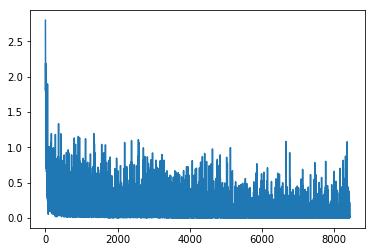

CPU times: user 17min 2s, sys: 4min 8s, total: 21min 10s
Wall time: 19min 11s


In [9]:
%time train_vgg16()
torch.save(vgg16.state_dict(), 'vgg16.pkl')
%time train_resnet18()
torch.save(resnet18.state_dict(), 'resnet18.pkl')

#### Testing
Once finetuning is done we need to test it on the test set.

In [10]:
def test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the ' + str(total) +' test images: %d %%' % (100 * correct / total))

Test the models

In [11]:
%time test(vgg16)
%time test(resnet18)

Accuracy of the network on the 1870 test images: 95 %
CPU times: user 36.7 s, sys: 9.96 s, total: 46.7 s
Wall time: 44.1 s
Accuracy of the network on the 1870 test images: 31 %
CPU times: user 10.5 s, sys: 2.44 s, total: 13 s
Wall time: 10.4 s


You can add more code to save the models if you want but otherwise this notebook is complete